In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
import yfinance as yf
from sklearn.linear_model import LinearRegression
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from numpy import array

In [15]:
from google.colab import drive 
drive.mount('/content/drive/')

!cp '/content/drive/MyDrive/TA-10/Dataset/MDKA.JK.csv' MDKA.JK.csv

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [16]:
df=pd.read_csv('MDKA.JK.csv')

In [17]:
df = df.reset_index(level=0)
df.head()

,index,Date,Open,High,Low,Close,Adj Close,Volume
0,0,12/6/2017,441.224579,441.224579,441.224579,441.224579,441.224579,0.0
1,1,12/7/2017,450.816406,450.816406,441.224579,441.224579,441.224579,911712.0
2,2,12/8/2017,441.224579,452.734772,427.795990,441.224579,441.224579,236138.0
3,3,12/11/2017,441.224579,441.224579,431.632721,431.632721,431.632721,2013691.0
4,4,12/12/2017,460.408234,460.408234,425.877625,450.816406,450.816406,8340.0


In [18]:
df=df[:-1]

In [19]:
df1=df.reset_index()['Close']

In [20]:
df1

0        441.224579
1        441.224579
2        441.224579
3        431.632721
4        450.816406
           ...     
1247    4090.000000
1248    4110.000000
1249    4150.000000
1250    4370.000000
1251    4440.000000
Name: Close, Length: 1252, dtype: float64

In [21]:
dataset = df.filter(['Close']).values

In [22]:
scaler=MinMaxScaler(feature_range=(0,1))
df2=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [23]:
df2

array([[0.00580283],
       [0.00580283],
       [0.00580283],
       ...,
       [0.70696493],
       [0.74855701],
       [0.76179085]])

#### Training

In [24]:
trainingDataLen = math.ceil(len(df2) * 0.80)
print('Size of trainingSet: ' + str(trainingDataLen))

Size of trainingSet: 1002


In [25]:
trainData = df2[:trainingDataLen , :]

In [26]:
# Split into trained x and y
xTrain = []
yTrain = []
for i in range(60, len(trainData)):
    xTrain.append(trainData[i-60:i , 0])
    yTrain.append(trainData[i , 0])

# Convert trained x and y as numpy array
xTrain, yTrain = np.array(xTrain), np.array(yTrain)
print('x - y train shape: ' + str(xTrain.shape) + ' ' + str(yTrain.shape))

# Reshape x trained data as 3 dimension array
xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))
print('Expected x train shape: ' + str(xTrain.shape))

x - y train shape: (942, 60) (942,)
Expected x train shape: (942, 60, 1)


In [27]:
xTrain, yTrain = np.array(xTrain), np.array(yTrain)
print('x - y train shape: ' + str(xTrain.shape) + ' ' + str(yTrain.shape))

x - y train shape: (942, 60, 1) (942,)


In [28]:
estop=tf.keras.callbacks.EarlyStopping(monitor="loss", patience=125, verbose=1,
                                        restore_best_weights=True)

#### Learning Rate 0.001


In [29]:
model = Sequential()
model.add(LSTM(450, return_sequences=True, input_shape=(xTrain.shape[1], 1)))
model.add(LSTM(250, return_sequences=True))
model.add(LSTM(150, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae')
model.fit(xTrain, yTrain, batch_size=10, epochs=10000, callbacks=[estop])

Epoch 1/10000
95/95 [==============================] - 15s 18ms/step - loss: 0.0282
Epoch 2/10000
95/95 [==============================] - 1s 15ms/step - loss: 0.0259
Epoch 3/10000
95/95 [==============================] - 2s 16ms/step - loss: 0.0168
Epoch 4/10000
95/95 [==============================] - 2s 20ms/step - loss: 0.0163
Epoch 5/10000
95/95 [==============================] - 2s 21ms/step - loss: 0.0149
Epoch 6/10000
95/95 [==============================] - 2s 18ms/step - loss: 0.0142
Epoch 7/10000
95/95 [==============================] - 2s 17ms/step - loss: 0.0147
Epoch 8/10000
95/95 [==============================] - 2s 20ms/step - loss: 0.0124
Epoch 9/10000
95/95 [==============================] - 2s 20ms/step - loss: 0.0132
Epoch 10/10000
95/95 [==============================] - 1s 15ms/step - loss: 0.0141
Epoch 11/10000
95/95 [==============================] - 1s 15ms/step - loss: 0.0117
Epoch 12/10000
95/95 [==============================] - 2s 18ms/step - loss: 0.0120


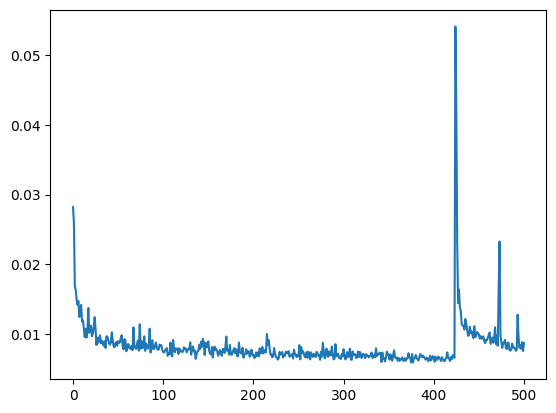

In [30]:
loss = model.history.history['loss']
plt.plot(loss)

In [31]:
testData = df2[trainingDataLen - 60: , :]

In [32]:
xTest = []
yTest = dataset[trainingDataLen: , :]
for i in range(60, len(testData)):
    xTest.append(testData[i - 60:i, 0])

In [33]:
xTest = np.array(xTest)

In [34]:
xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1], 1))

In [35]:
predictions = model.predict(xTest)
predictions = scaler.inverse_transform(predictions)

8/8 [==============================] - 1s 12ms/step


In [36]:
mape = np.mean(np.abs((yTest - predictions) / yTest)) * 100
print('\nMAPE:' + str(mape))


MAPE:3.032131926786224


#### Visualisasi

In [37]:
print(predictions)

[[3522.6028]
 [3650.1997]
 [3616.207 ]
 [3687.5293]
 [3737.6636]
 [3663.796 ]
 [3660.6562]
 [3718.0574]
 [3761.9277]
 [3840.1501]
 [3771.8323]
 [3756.6914]
 [3608.6987]
 [3584.1345]
 [3647.226 ]
 [3644.9573]
 [3772.0408]
 [3800.2578]
 [3860.3262]
 [3882.3025]
 [3841.6277]
 [3934.408 ]
 [3918.3672]
 [3910.554 ]
 [3896.244 ]
 [4034.8762]
 [3967.6724]
 [3936.0508]
 [3988.0046]
 [3884.1445]
 [3876.0889]
 [3867.1243]
 [3873.7683]
 [3978.2246]
 [3988.3396]
 [4013.615 ]
 [3976.8171]
 [3843.4695]
 [3837.9739]
 [3865.0093]
 [3845.8997]
 [3870.702 ]
 [3800.4873]
 [3723.5806]
 [3627.901 ]
 [3613.4568]
 [3683.7307]
 [3642.4106]
 [3666.0679]
 [3677.2456]
 [3594.747 ]
 [3599.4146]
 [3544.197 ]
 [3587.4978]
 [3634.617 ]
 [3711.7446]
 [3791.2888]
 [3859.781 ]
 [3869.2659]
 [3812.6816]
 [3762.2466]
 [3793.9275]
 [3778.5137]
 [3823.224 ]
 [3825.1072]
 [3874.2659]
 [4078.579 ]
 [4152.4463]
 [4472.0454]
 [4592.3853]
 [4368.59  ]
 [4184.8926]
 [4117.618 ]
 [4098.4624]
 [4047.752 ]
 [4250.8574]
 [4237.6836]

In [38]:
train = df.loc[:trainingDataLen, ['Date', 'Close'] ]
valid = df.loc[trainingDataLen:, ['Date', 'Close'] ]
print('validLength: {}, predictionLength: {}'.format(len(valid), len(predictions)))

validLength: 250, predictionLength: 250


In [39]:
dfPrediction = pd.DataFrame(predictions, columns = ['predictions'])

In [40]:
valid = valid.reset_index()
dfPrediction = dfPrediction.reset_index()

In [41]:
valid = pd.concat([valid, dfPrediction], axis=1)

In [42]:
print(valid)

     index        Date   Close  index  predictions
0     1002  11/29/2021  3740.0      0  3522.602783
1     1003  11/30/2021  3660.0      1  3650.199707
2     1004   12/1/2021  3710.0      2  3616.207031
3     1005   12/2/2021  3690.0      3  3687.529297
4     1006   12/3/2021  3650.0      4  3737.663574
..     ...         ...     ...    ...          ...
245   1247  11/28/2022  4090.0    245  4309.124023
246   1248  11/29/2022  4110.0    246  4139.208008
247   1249  11/30/2022  4150.0    247  4103.467285
248   1250   12/1/2022  4370.0    248  4071.548096
249   1251   12/2/2022  4440.0    249  4139.248535

[250 rows x 5 columns]


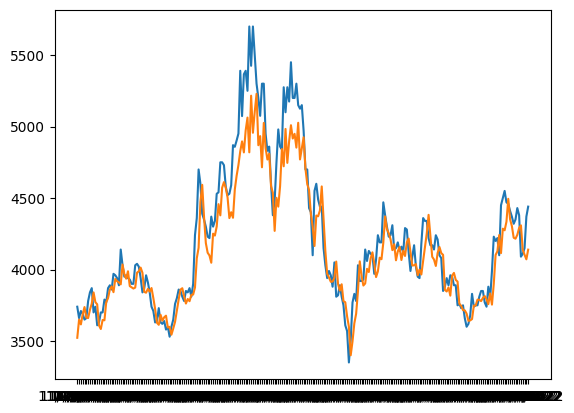

In [43]:
plt.plot(valid['Date'], valid[['Close', 'predictions']])

#### Predictions


In [44]:
for i in range(30):
  x_for_pred = df2[-60:].reshape(1, 60, 1)
  prediction = model.predict(x_for_pred)
  df2 = np.append(df2, prediction)

1/1 [==============================] - 0s 21ms/step


In [45]:
predictFor30D = df2[-30:]

In [46]:
predictFor30D = predictFor30D.reshape(-1, 1)
predictFor30D = scaler.inverse_transform(predictFor30D)
predictFor30D

array([[4280.02797949],
       [4313.7723855 ],
       [4358.55369131],
       [4291.12005274],
       [4183.66295264],
       [4133.05343735],
       [4098.7954452 ],
       [4055.17246686],
       [4010.21019209],
       [3992.50833782],
       [3984.78594449],
       [3975.34560711],
       [3966.8463714 ],
       [3961.63421305],
       [3957.42904925],
       [3951.19381723],
       [3943.28036607],
       [3934.63610297],
       [3925.21026833],
       [3914.57187859],
       [3902.88803053],
       [3890.73536565],
       [3878.55558696],
       [3866.62456177],
       [3855.23455181],
       [3844.68349378],
       [3835.13848446],
       [3826.5976322 ],
       [3818.96036364],
       [3812.08228194]])

In [47]:
import datetime

def date_weekday(from_date, add_days):
    weekday_to_add = add_days
    current_date = from_date
    while weekday_to_add > 0:
        current_date += datetime.timedelta(days=1)
        weekday = current_date.weekday()
        if weekday >= 5:
            continue
        weekday_to_add -= 1
    return current_date

datenow = datetime.date.today()
datePred = []

for x in range (30):
    hariKerja = date_weekday(datenow,1)
    datenow = hariKerja
    datePred.append(hariKerja)

In [48]:
predictFor30D = pd.DataFrame(predictFor30D, columns = ['Prediction'])

In [49]:
datePred = pd.DataFrame(datePred, columns = ['Date'])

In [50]:
datePred = datePred.reset_index()
predictFor30D = predictFor30D.reset_index()

In [51]:
finalPred = pd.concat([datePred, predictFor30D], axis=1)

In [52]:
finalPred = finalPred.drop(columns=['index'])

In [53]:
finalPred

,Date,Prediction
0,2023-06-05,4280.027979
1,2023-06-06,4313.772386
2,2023-06-07,4358.553691
3,2023-06-08,4291.120053
4,2023-06-09,4183.662953
5,2023-06-12,4133.053437
6,2023-06-13,4098.795445
7,2023-06-14,4055.172467
8,2023-06-15,4010.210192
9,2023-06-16,3992.508338


TypeError: ignored

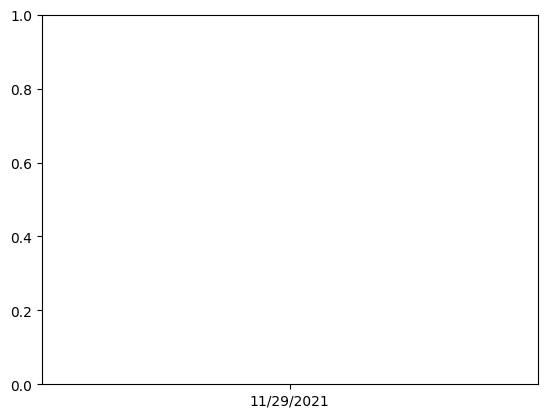

In [54]:
plt.plot(valid['Date'], valid['Close'], 'b', finalPred['Date'], finalPred['Prediction'], 'orange')
plt.show()

In [55]:
model.save('MDKA.h5')